In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
%matplotlib inline

In [2]:
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


### Step 1. Setting hyperparameters for GAN

In [3]:
real_image_size = 784 #Only for MNIST dataset  28x28x1 = 784
g_hidden_size = 128 # This is how many nodes we use in a hidden layer in Generator
d_hidden_size = 128 # This is how many nodes we use in a hidden layer in Discriminator
learning_rate = 0.002 # Learning rate - parameter used for gradient descent
epochs = 100 # How many times do we run through whole network
z_size = 100 # The size of the latent vector which is the input to Generator
smooth = 0.1 # Smoothing value used at the end of Discriminator, this param helps classificator to converge better
batch_size = 100 # How many images we feed to the GAN at ones

NOTE: Almost at every layer I have used Leaky relu activation function which is not implemented as a part of TensorFlow library. 

This line is the implementation of leaky relu: `tf.maximum(layer * alpha, layer)`

![](l_relu.png)
*The graph for Leaky relu*

### Step 2. Define helper functions

In [4]:
def generator(inputs, hidden_size, reuse=False, alpha=0.01):
    
    with tf.variable_scope('generator', reuse=reuse):
        
        layer = tf.layers.dense(inputs, hidden_size, activation=None)
        layer = tf.maximum(layer*alpha, layer)
        
        logits = tf.layers.dense(layer, real_image_size, activation=None)
        output = tf.tanh(logits)
        
        return output

In [5]:
def discriminator(inputs, hidden_size, reuse=False, alpha=0.01):
    
    with tf.variable_scope('discriminator', reuse=reuse):
        
        layer = tf.layers.dense(inputs, hidden_size, activation=None)
        layer = tf.maximum(layer*alpha, layer)
        
        logits = tf.layers.dense(layer, 1, activation=None)
        output = tf.sigmoid(logits)
        
        return logits, output

### Step 3. Define GAN

In [6]:
# Inputs to our network
inputs = tf.placeholder(tf.float32, [None, real_image_size], name='real_img_input')
latent_input = tf.placeholder(tf.float32, [None, z_size], name='fake_img_input')

#### Steo 3.2 Define Generator

In [7]:
#Generator outputs 
gen_out = generator(latent_input, g_hidden_size, reuse=False)

#### Step 3.3 Define Discriminator

In [8]:
# Discriminator outputs for REAL images inputs
real_disc_logits, real_disc_output = discriminator(inputs, d_hidden_size, reuse=False)
# Discriminator outputs for FAKE images inputs
fake_disc_logits, fake_disc_output = discriminator(gen_out, d_hidden_size, reuse=True)

#### Step 3.4 Define losses for Generator and Discriminator

In [9]:
#Loss for discriminator - Real images
dis_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=real_disc_logits, 
                                                                       labels=tf.ones_like(real_disc_logits) * (1 - smooth)))
# Loss for discriminator - Fake images
dis_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_disc_logits, 
                                                                       labels=tf.zeros_like(fake_disc_logits)))
#Total loss for Discriminator
dis_loss = dis_loss_real + dis_loss_fake
#Loss for Generator
gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_loss_fake, 
                                                                       labels=tf.ones_like(dis_loss_fake)))

In [10]:
#Getting all trainable variables from GAN
trainable_vars = tf.trainable_variables()

#### Step 3.5 Get lists of variables connected to Generator and Discriminator

In [11]:
#Separate vars used for generator and for discriminator
gen_vars = [var for var in trainable_vars if var.name.startswith('generator')]
dis_vars = [var for var in trainable_vars if var.name.startswith('discriminator')]

#### Step 3.6 Define Generator and Discriminator Optimizers

In [12]:
#Optimize separatelly variables for Generator and for Discriminator
dis_optimizer = tf.train.AdamOptimizer(learning_rate).minimize(dis_loss, var_list=dis_vars)
gen_optimizer = tf.train.AdamOptimizer(learning_rate).minimize(gen_loss, var_list=gen_vars)

### Step 4. Train

In [13]:
session = tf.Session()

In [14]:
session.run(tf.global_variables_initializer())

In [16]:
total_loss = []
samples = []
losses = []
for i in range(epochs):    
    for ii in range(mnist.train.num_examples // batch_size):
        batch = mnist.train.next_batch(batch_size)
        
        batch_images = batch[0].reshape((batch_size, real_image_size))
        batch_images = batch_images * 2 - 1 # Normalize images
        
        latent_space = np.random.uniform(-1, 1, size=(batch_size, z_size))
        
        c_d, _ = session.run([dis_loss, dis_optimizer], feed_dict={inputs:batch_images, latent_input:latent_space})
        c_g, _ = session.run([gen_loss, gen_optimizer], feed_dict={latent_input:latent_space})
        
    
    losses.append((c_g, c_d))
    
    print('Epoch: {}/{}'.format(i, epochs), " | Generator loss: {:.4f}".format(c_g),
          " | Discriminator loss: {:.4f}".format(c_d))
    
    
    sample_z = np.random.uniform(-1, 1, size=(16, z_size))
    gen_samples = session.run(
                   generator(latent_input, hidden_size=g_hidden_size, reuse=True),
                   feed_dict={latent_input: sample_z})
    samples.append(gen_samples)

Epoch: 0/100  | Generator loss: 0.6931  | Discriminator loss: 0.3252
Epoch: 1/100  | Generator loss: 0.6931  | Discriminator loss: 0.3251
Epoch: 2/100  | Generator loss: 0.6931  | Discriminator loss: 0.3251
Epoch: 3/100  | Generator loss: 0.6931  | Discriminator loss: 0.3251
Epoch: 4/100  | Generator loss: 0.6931  | Discriminator loss: 0.3251
Epoch: 5/100  | Generator loss: 0.6931  | Discriminator loss: 0.3251
Epoch: 6/100  | Generator loss: 0.6931  | Discriminator loss: 0.3251
Epoch: 7/100  | Generator loss: 0.6931  | Discriminator loss: 0.3251
Epoch: 8/100  | Generator loss: 0.6790  | Discriminator loss: 0.3778
Epoch: 9/100  | Generator loss: 0.6812  | Discriminator loss: 0.3602
Epoch: 10/100  | Generator loss: 0.6543  | Discriminator loss: 0.5282
Epoch: 11/100  | Generator loss: 0.6110  | Discriminator loss: 0.8267
Epoch: 12/100  | Generator loss: 0.5351  | Discriminator loss: 1.1351
Epoch: 13/100  | Generator loss: 0.6035  | Discriminator loss: 0.7684
Epoch: 14/100  | Generator los

In [19]:
# fig, ax = plt.subplots()
# losses = np.array(losses)
# plt.plot(losses.T[0], label='Generator')
# plt.plot(losses.T[1], label='Discriminator')
# plt.title("Training Losses")
# plt.legend()

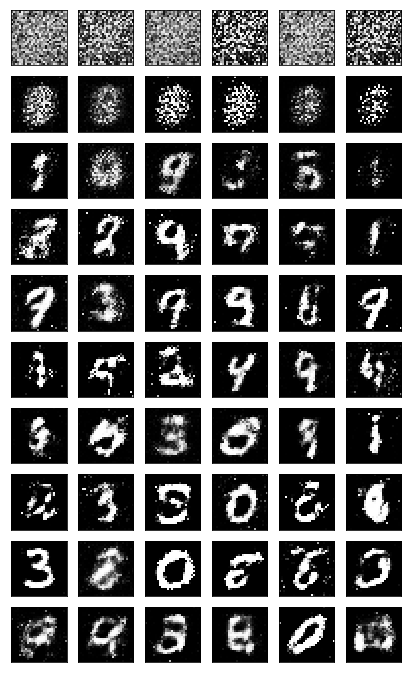

In [20]:
rows, cols = 10, 6
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)